In [ ]:
# Compute edit distance with WFST

# https://github.com/revdotcom/fstalign/blob/develop/src/fstalign.cpp#L197
# https://www.statmt.org/wmt16/pdf/W16-2324.pdf
# https://aclanthology.org/P14-2102.pdf
# https://github.com/k2-fsa/k2/issues/746

In [1]:
import sys
sys.path.insert(0,'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg')
sys.path.insert(0,'/exp/rhuang/meta/k2/k2/python')
sys.path.insert(0,'/exp/rhuang/meta/k2/temp.linux-x86_64-cpython-310/lib')
sys.path.insert(0,'/exp/rhuang/meta/icefall')

In [2]:
import k2
import sentencepiece as spm
import torch
import pywrapfst as openfst
from icefall.decode import get_lattice, one_best_decoding
from icefall.utils import get_alignments, get_texts, get_texts_with_timestamp
from data_long_dataset import *
from pathlib import Path

/home/hltcoe/rhuang/mambaforge/envs/aligner5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sp = spm.SentencePieceProcessor()
sp.load("/exp/rhuang/meta/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [4]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[19, 100, 69, 414, 10, 15, 18, 79],
 [153, 33, 370, 23, 3, 231, 100, 52, 3],
 [49, 12, 5, 145, 19]]

# Compute edit distance with WFST

In [13]:
word_ids_list1 = [24, 102, 70, 393, 12, 17, 19, 80]
word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

# word_ids_list1 = list(range(800, 900)) + [24, 102, 70, 393, 12, 17, 19, 80] + list(range(800, 900))
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

# word_ids_list1 = [77] * 100 + [24, 102, 70, 393, 12, 17, 19, 80] + [77] * 100
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

In [150]:
# graph1 = k2.ctc_graph([word_ids_list1], modified=False, device='cpu')[0]
# graph2 = k2.ctc_graph([word_ids_list2], modified=False, device='cpu')[0]

# graph1 = k2.linear_fsa([word_ids_list1], device='cpu')[0]
# graph2 = k2.linear_fsa([word_ids_list2], device='cpu')[0]

graph1 = k2.linear_fst(labels=[word_ids_list1], aux_labels=[word_ids_list1])[0]
graph2 = k2.linear_fst(labels=[word_ids_list2], aux_labels=[word_ids_list2])[0]

In [21]:
k2.to_dot(graph1)

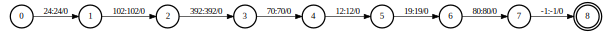

In [22]:
k2.to_dot(graph2)

In [6]:
def get_linear_fst(word_ids_list, blank_id=0, max_symbol_id=1000, input_side=True, return_str=False):
    graph = k2.linear_fst(labels=[word_ids_list], aux_labels=[word_ids_list])[0]

    max_symbol_id += 1

    c_str = k2.to_str_simple(graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]

    new_arcs = []
    for i, (ss, ee, l1, l2, w) in enumerate(arcs):
        if l1 > 0:
            # substitution
            if input_side:
                new_arcs.append([ss, ee, max_symbol_id, l2, -1])
            else:
                new_arcs.append([ss, ee, l1, max_symbol_id, -1])
            
            # deletion
            new_arcs.append([ss, ee, l1, blank_id, -2])
        
        # insertion
        if input_side:
            new_arcs.append([ss, ss, max_symbol_id, blank_id, -2])
        else:
            new_arcs.append([ss, ss, blank_id, max_symbol_id, -2])
    
    new_arcs = arcs + new_arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        fst = k2.arc_sort(fst)
        return fst

In [14]:
graph1 = get_linear_fst(word_ids_list1, max_symbol_id=1000, blank_id=0, input_side=False, return_str=False)
graph2 = get_linear_fst(word_ids_list2, max_symbol_id=1000, blank_id=0, input_side=True, return_str=False)

In [37]:
# print(graph1)
# graph1.arcs.values()

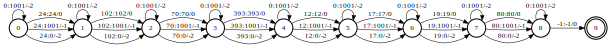

In [15]:
k2.to_dot(graph1)

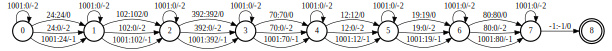

In [16]:
k2.to_dot(graph2)

In [134]:
rs = k2.compose(graph1, graph2, treat_epsilons_specially=True)
rs = k2.connect(rs)
rs = k2.remove_epsilon_self_loops(rs)
# rs = k2.arc_sort(rs)
rs = k2.top_sort(rs)  # top-sort is needed: https://github.com/k2-fsa/k2/issues/746#issuecomment-856503238

rs.shape, rs.num_arcs

((1673, None), 6260)

In [113]:
rs.arcs.values()

tensor([[          0,           1,          24, -1073741824],
        [          0,           3,          24,           0],
        [          0,           3,          24, -1073741824],
        ...,
        [         69,          71,          80, -1069547520],
        [         70,          71,           0, -1069547520],
        [         71,          72,          -1,           0]],
       dtype=torch.int32)

In [103]:
rs.labels

tensor([ 24,  24,   0,  24,  24, 102, 102,   0, 102, 102,   0,  24,  24,   0,
        102, 102,   0,  70,  70,   0, 102, 102,   0,  70,  70,   0,  24,  24,
          0,  70,  70,  70,  70,   0,  70,  70,   0, 393, 393,   0, 393, 393,
          0, 102, 102,   0, 393, 393,   0,  24,  24,   0, 393, 393,   0, 393,
        393,   0,  70,  70,   0,  12,  12,   0,  12,  12,  12,  12,   0,  12,
         12,   0, 102, 102,   0,  12,  12,   0,  24,  24,   0,  12,  12,   0,
        393, 393,   0,  12,  12,   0,  70,  70,   0,  17,  17,   0,  17,  17,
          0,  17,  17,   0,  17,  17,   0, 102, 102,   0,  17,  17,   0,  24,
         24,   0,  17,  17,   0, 393, 393,   0,  12,  12,   0,  17,  17,   0,
         70,  70,   0,  19,  19,   0,  19,  19,   0,  19,  19,  19,  19,   0,
         19,  19,   0,  19,  19,   0, 102, 102,   0,  19,  19,   0,  24,  24,
          0,  19,  19, 393,  12,  17,  19,  70,   0,  80,  80,   0,  80,  80,
          0,  80,  80,   0,  80,  80,  80,  80,   0,  80,  80,  

In [ ]:
k2.to_dot(rs)

In [136]:
rs_vec = k2.create_fsa_vec([rs])

# best_path = one_best_decoding(
#     lattice=rs_vec,
#     use_double_scores=True,
# )

best_path = k2.shortest_path(rs_vec, use_double_scores=True)
best_path.shape, best_path.num_arcs

((1, None, None), 209)

In [116]:
rs.properties
rs.properties_str

'"Valid|Nonempty|TopSorted|TopSortedAndAcyclic|MaybeAccessible|MaybeCoaccessible"'

In [ ]:
k2.to_dot(best_path[0])

In [118]:
hyps = get_texts(best_path)
print(f"hyps={hyps}")

hyps=[[24, 102, 392, 70, 12, 19, 80]]


In [131]:
edit_distance = best_path.get_tot_scores(log_semiring=False, use_double_scores=False) / 2
edit_distance

tensor([-20003.])

# Compute edit distance for the alignment results and `arange`

In [5]:
from alignment import *

In [6]:
# f="/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/exp/exp_seed_small_model5/ali_-18/7327/93283/93283.pt"
f = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/exp/exp_seed_small_model/ali_-100/2671/157946/157946.pt"
rs = torch.load(f)
rs.keys()

dict_keys(['meta_data', 'hyps', 'timestamps', 'output_frame_offset'])

In [7]:
hyps = rs['hyps']
timestamps = rs['timestamps']
output_frame_offset = rs['output_frame_offset']
meta_data = rs['meta_data']

In [9]:
meta_data

{'book_id': ['2600'],
 'chapter_id': ['157946'],
 'speaker_id': ['2671'],
 'audio_path': ['LibriSpeechOriginal/LibriSpeech/mp3/2671/157946/157946.mp3'],
 'text_path': ['LibriSpeechAligned/LibriSpeech/books/ascii/2600/2600.txt']}

In [18]:
len(hyps), len(timestamps), len(output_frame_offset), len(meta_data)
# This many segments of (segment_size - overlap) seconds, e.g., 28 seconds

(20, 20, 20, 5)

In [19]:
i = 0
print(hyps[i])
print(timestamps[i])
print(output_frame_offset[i])

[285430, 285432, 285433, 285440, 285441, 285443, 285444, 285448, 285453, 285460, 285461, 285462, 285468, 285469, 285471, 285472, 285474, 285481, 285485, 285486, 285487, 285488, 285495, 285497, 285498, 285499, 285502, 285503, 285504, 285506, 285508, 285510, 285512, 285513, 285514]
[20, 31, 49, 71, 112, 139, 161, 168, 287, 315, 322, 335, 381, 386, 438, 445, 448, 469, 477, 481, 494, 499, 548, 555, 573, 590, 619, 645, 655, 661, 687, 693, 725, 731, 732]
tensor(0, dtype=torch.int32)


In [11]:
i = 1
print(hyps[i])
print(timestamps[i])
print(output_frame_offset[i])

[24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434, 24435, 24436, 24438, 24440, 24441, 24442, 24444, 24445, 24446, 24447, 24448, 24449, 24450, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24465, 24466, 24467, 24468, 24469, 24470, 24472, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24485, 24486, 24487, 24488, 24489]
[6, 10, 16, 20, 25, 29, 35, 61, 67, 71, 78, 81, 100, 111, 123, 127, 132, 141, 170, 180, 184, 189, 192, 202, 205, 209, 217, 219, 223, 226, 233, 238, 244, 270, 274, 278, 302, 305, 308, 320, 324, 329, 337, 351, 400, 403, 411, 425, 429, 437, 441, 445, 447, 451, 464, 468, 472, 477, 486, 489, 499, 502, 508, 513, 517, 554, 560, 563, 567, 572, 582, 587, 601, 611, 617, 622, 6

In [13]:
torch.Tensor(timestamps[i]) + output_frame_offset[i]

tensor([ 706.,  710.,  716.,  720.,  725.,  729.,  735.,  761.,  767.,  771.,
         778.,  781.,  800.,  811.,  823.,  827.,  832.,  841.,  870.,  880.,
         884.,  889.,  892.,  902.,  905.,  909.,  917.,  919.,  923.,  926.,
         933.,  938.,  944.,  970.,  974.,  978., 1002., 1005., 1008., 1020.,
        1024., 1029., 1037., 1051., 1100., 1103., 1111., 1125., 1129., 1137.,
        1141., 1145., 1147., 1151., 1164., 1168., 1172., 1177., 1186., 1189.,
        1199., 1202., 1208., 1213., 1217., 1254., 1260., 1263., 1267., 1272.,
        1282., 1287., 1301., 1311., 1317., 1322., 1328., 1335., 1340., 1347.,
        1376., 1379., 1382., 1389., 1392., 1394., 1397., 1401., 1404., 1408.])

In [23]:
# my_hyps = [hyps[0], hyps[1], hyps[2], hyps[3], hyps[4]]
my_hyps = [hyps[-5], hyps[-4], hyps[-3], hyps[-2], hyps[-1]]
best_paths, rs_list1, rs_list2, rs_list2_, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max = get_aligned_list(my_hyps)
best_paths.shape, best_paths.num_arcs, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max

((1, None, None), 158, 258066, 257815, 257948)

In [19]:
# k2.to_dot(best_paths[0])

In [68]:
rs_list2

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 -1,
 42,
 -1,
 43,
 44,
 45,
 -1,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 -1,
 66,
 67,
 68,
 69,
 70,
 71,
 -1,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 -1,
 10,
 11,
 12,
 13,
 14,
 -1,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 -1,
 39,
 -1,
 40,
 41,
 42,


In [66]:
# hyps = get_texts(best_path)
# print(f"hyps={hyps}")

# print(best_paths[0].labels.tolist())
# print(best_paths[0].aux_labels.tolist())

# print(*list(zip(best_paths[0].labels.tolist(), best_paths[0].aux_labels.tolist())), sep="\n")
print(*list(zip(rs_list1, rs_list2, rs_list2_)), sep="\n")

(0, 0, 525090)
(0, 1, 525091)
(0, 2, 525093)
(0, 3, 525095)
(0, 4, 525097)
(0, 5, 525100)
(0, 6, 525103)
(0, 7, 525104)
(0, 8, 525105)
(0, 9, 525107)
(0, 10, 525109)
(0, 11, 525111)
(0, 12, 525112)
(0, 13, 525113)
(0, 14, 525115)
(0, 15, 525119)
(0, 16, 525121)
(0, 17, 525122)
(0, 18, 525123)
(0, 19, 525124)
(0, 20, 525128)
(0, 21, 525134)
(0, 22, 525140)
(0, 23, 525142)
(0, 24, 525148)
(0, 25, 525153)
(0, 26, 525155)
(0, 27, 525167)
(0, 28, 525170)
(0, 29, 525172)
(0, 30, 525173)
(0, 31, 525175)
(0, 32, 525178)
(0, 33, 525181)
(0, 34, 525186)
(0, 35, 525192)
(0, 36, 525193)
(0, -1, 525293)
(0, 0, 88161)
(0, 1, 88163)
(0, 2, 88164)
(0, 3, 88165)
(0, 4, 88169)
(0, 5, 88172)
(0, 6, 88173)
(0, 7, 88184)
(0, 8, 88187)
(0, 9, 88193)
(0, 10, 88203)
(0, 11, 88206)
(0, 12, 88208)
(0, 13, 88211)
(0, 14, 88214)
(0, 15, 88215)
(0, 16, 88220)
(0, 17, 88222)
(0, 18, 88223)
(0, 19, 88227)
(0, 20, 88228)
(0, 21, 88230)
(0, 22, 88231)
(0, 23, 88232)
(0, 24, 88243)
(0, 25, 88249)
(0, 26, 88258)
(0, 27,

In [62]:
len(timestamps[3])

94

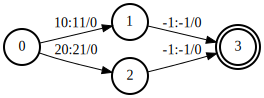

In [51]:
s = '''
0 1 10 11 0
0 2 20 21 0
1 3 -1 -1 0
2 3 -1 -1 0
3
'''
fsa = k2.Fsa.from_str(s, acceptor=False)
k2.to_dot(fsa)

In [52]:
fsa.arcs.values()

tensor([[ 0,  1, 10,  0],
        [ 0,  2, 20,  0],
        [ 1,  3, -1,  0],
        [ 2,  3, -1,  0]], dtype=torch.int32)

In [53]:
fsa.labels, fsa.aux_labels

(tensor([10, 20, -1, -1], dtype=torch.int32),
 tensor([11, 21, -1, -1], dtype=torch.int32))

In [8]:
alignment_results, to_realign = align_long_text(rs, num_segments_per_chunk=5, neighbor_threshold=5)

Processing chunks: 0 to 5
Processing chunks: 5 to 10
Processing chunks: 10 to 15
Processing chunks: 15 to 20
Processing chunks: 20 to 25
Processing chunks: 25 to 30
Processing chunks: 30 to 35
Processing chunks: 35 to 40
Processing chunks: 40 to 45


In [14]:
long_dataset = LibrispeechLongAudioDataset(
    root = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/download/",
    skip_loading_audio = True,
    # skip_text_normalization = True,
    # manifest_file = None,
)
long_dataset_index = {Path(long_dataset.manifest[i][0]).parent.stem: i for i in range(len(long_dataset))}  # chapter id => index

In [15]:
waveform, sample_rate, text, speaker_id, chapter_id, meta_data  = long_dataset[long_dataset_index[Path(meta_data["audio_path"][0]).parent.stem]]
# waveform, sample_rate, text, speaker_id, chapter_id, meta_data  = long_dataset[long_dataset_index[Path(meta_data["audio_path"]).parent.stem]]
text = text.split()

In [29]:
alignment_results_ = [(text[k], v*0.04) for k, v in sorted(alignment_results.items())]

In [30]:
print(len(alignment_results_))
alignment_results_

1119


[('FOR', 13.4),
 ('WHICH', 13.6),
 ('MARYA', 13.84),
 ('HAD', 14.8),
 ('TAKEN', 15.0),
 ('A', 15.32),
 ('BOX', 15.44),
 ('NOT', 16.8),
 ('WANT', 17.52),
 ('TO', 17.8),
 ('GO', 17.92),
 ('BUT', 18.76),
 ('COULD', 18.96),
 ('NOT', 19.080000000000002),
 ('REFUSE', 19.240000000000002),
 ('MARYA', 19.76),
 ('KIND', 20.8),
 ('OFFER', 21.16),
 ('WHICH', 21.92),
 ('WAS', 22.2),
 ('INTENDED', 22.28),
 ('EXPRESSLY', 22.92),
 ('FOR', 23.400000000000002),
 ('HER', 23.6),
 ('WHEN', 24.76),
 ('SHE', 24.96),
 ('CAME', 25.16),
 ('READY', 25.48),
 ('DRESSED', 25.76),
 ('INTO', 26.2),
 ('THE', 26.32),
 ('BALLROOM', 26.44),
 ('TO', 26.92),
 ('AWAIT', 27.04),
 ('HER', 27.48),
 ('FATHER', 27.68),
 ('AND', 27.72),
 ('LOOKING', 28.72),
 ('IN', 29.0),
 ('THE', 29.12),
 ('LARGE', 29.240000000000002),
 ('MIRROR', 29.6),
 ('SAW', 30.240000000000002),
 ('THAT', 30.48),
 ('SHE', 30.64),
 ('WAS', 30.88),
 ('PRETTY', 31.0),
 ('VERY', 31.68),
 ('PRETTY', 32.08),
 ('SHE', 32.76),
 ('FELT', 32.92),
 ('EVEN', 33.24),
 (

In [31]:
# To audacity: https://manual.audacityteam.org/man/importing_and_exporting_labels.html

audacity_labels_str = "\n".join([f"{t:.2f}\t{t:.2f}\t{label}" for label, t in alignment_results_])
# print(audacity_labels)
with open("audacity_labels.txt", "w") as fout:
    print(audacity_labels_str, file=fout)

str(Path("audacity_labels.txt").absolute())

'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/audacity_labels.txt'

In [32]:
long_dataset.root + "/" + meta_data["audio_path"]

'/exp/rhuang/meta/icefall/egs/librispeech/ASR/download//LibriSpeechOriginal/LibriSpeech/mp3/2671/157946/157946.mp3'

In [64]:
hyps[-2]

[427233,
 427237,
 427239,
 427241,
 427242,
 427245,
 427246,
 427247,
 427248,
 427250,
 427258,
 427259,
 427260,
 427263,
 427268,
 427270,
 427276,
 427277,
 427280,
 427283,
 427284,
 427287,
 427288,
 427290,
 427292,
 427294,
 427298,
 427300,
 427302,
 427310,
 427311,
 427312,
 427313,
 427314,
 427315,
 427316]

In [50]:
text[285430]

'WAR'

In [56]:
[text[i] for i in hyps[0]]

['WAR',
 'PEACE',
 'BARCLAY',
 'CAPABLE',
 'OF',
 'ALL',
 'BUT',
 'SO',
 'MOVEMENTS',
 'THESE',
 'COURTIERS',
 'PFUEL',
 'AND',
 'BARCLAY',
 'ON',
 'TO',
 'DOES',
 'AND',
 'NO',
 'RESULT',
 'BAGRATION',
 'ALONE',
 'BUT',
 'HAS',
 'EXPERIENCE',
 'A',
 'AND',
 'RESOLUTION',
 'AND',
 'ROLE',
 'YOUR',
 'MONARCH',
 'IN',
 'THAT',
 'MONSTROUS']

In [63]:
output_frame_offset

tensor([    0,   700,  1400,  2100,  2800,  3500,  4200,  4900,  5600,  6300,
         7000,  7700,  8400,  9100,  9800, 10500, 11200, 11900, 12600, 13300],
       dtype=torch.int32)

In [12]:
alignment_results

{256499: 335,
 256500: 340,
 256501: 346,
 256503: 370,
 256504: 375,
 256505: 383,
 256506: 386,
 256509: 420,
 256510: 438,
 256511: 445,
 256512: 448,
 256513: 469,
 256514: 474,
 256515: 477,
 256516: 481,
 256517: 494,
 256519: 520,
 256520: 529,
 256521: 548,
 256522: 555,
 256523: 557,
 256524: 573,
 256525: 585,
 256526: 590,
 256527: 619,
 256528: 624,
 256529: 629,
 256530: 637,
 256531: 644,
 256532: 655,
 256533: 658,
 256534: 661,
 256535: 673,
 256536: 676,
 256537: 687,
 256538: 692,
 256539: 693,
 256540: 718,
 256541: 725,
 256542: 728,
 256543: 731,
 256544: 740,
 256546: 756,
 256547: 762,
 256548: 766,
 256549: 772,
 256550: 775,
 256551: 792,
 256552: 802,
 256553: 819,
 256554: 823,
 256555: 831,
 256556: 835,
 256557: 842,
 256558: 855,
 256559: 858,
 256560: 864,
 256561: 866,
 256562: 869,
 256564: 893,
 256565: 924,
 256566: 933,
 256567: 952,
 256568: 956,
 256569: 961,
 256572: 981,
 256573: 984,
 256574: 989,
 256575: 995,
 256576: 1010,
 256577: 1012,
 256

In [10]:
len(to_realign)

67

In [11]:
to_realign

[(256502, 256503),
 (256507, 256509),
 (256518, 256519),
 (256545, 256546),
 (256563, 256564),
 (256570, 256572),
 (256661, 256665),
 (256688, 256689),
 (256693, 256695),
 (256700, 256705),
 (256825, 256865),
 (256900, 256929),
 (256945, 256946),
 (257009, 257010),
 (257012, 257013),
 (257035, 257042),
 (257048, 257049),
 (257066, 257113),
 (257119, 257120),
 (257184, 257185),
 (257189, 257193),
 (257202, 257203),
 (257209, 257222),
 (257231, 257233),
 (257266, 257267),
 (257268, 257319),
 (257332, 257336),
 (257347, 257348),
 (257353, 257354),
 (257362, 257363),
 (257372, 257373),
 (257381, 257421),
 (257434, 257435),
 (257462, 257463),
 (257478, 257479),
 (257496, 257497),
 (257509, 257510),
 (257517, 257518),
 (257521, 257522),
 (257525, 257528),
 (257556, 257557),
 (257565, 257566),
 (257567, 257568),
 (257614, 257615),
 (257628, 257630),
 (257651, 257652),
 (257659, 257660),
 (257662, 257663),
 (257665, 257667),
 (257673, 257676),
 (257694, 257695),
 (257700, 257702),
 (257719, 25

In [16]:
text[256490:256490+100]

['GUESTS',
 'THAT',
 'EVENING',
 'THE',
 'ROSTOVS',
 'WENT',
 'TO',
 'THE',
 'OPERA',
 'FOR',
 'WHICH',
 'MARYA',
 'DMITRIEVNA',
 'HAD',
 'TAKEN',
 'A',
 'BOX',
 'NATASHA',
 'DID',
 'NOT',
 'WANT',
 'TO',
 'GO',
 'BUT',
 'COULD',
 'NOT',
 'REFUSE',
 'MARYA',
 'DMITRIEVNAS',
 'KIND',
 'OFFER',
 'WHICH',
 'WAS',
 'INTENDED',
 'EXPRESSLY',
 'FOR',
 'HER',
 'WHEN',
 'SHE',
 'CAME',
 'READY',
 'DRESSED',
 'INTO',
 'THE',
 'BALLROOM',
 'TO',
 'AWAIT',
 'HER',
 'FATHER',
 'AND',
 'LOOKING',
 'IN',
 'THE',
 'LARGE',
 'MIRROR',
 'THERE',
 'SAW',
 'THAT',
 'SHE',
 'WAS',
 'PRETTY',
 'VERY',
 'PRETTY',
 'SHE',
 'FELT',
 'EVEN',
 'MORE',
 'SAD',
 'BUT',
 'IT',
 'WAS',
 'A',
 'SWEET',
 'TENDER',
 'SADNESS',
 'O',
 'GOD',
 'IF',
 'HE',
 'WERE',
 'HERE',
 'NOW',
 'I',
 'WOULD',
 'NOT',
 'BEHAVE',
 'AS',
 'I',
 'DID',
 'THEN',
 'BUT',
 'DIFFERENTLY',
 'I',
 'WOULD',
 'NOT',
 'BE',
 'SILLY',
 'AND',
 'AFRAID',
 'OF']